# С какими данными работают аналитики фондового рынка. Как найти и скачать нужные данные

**Цель занятия - показать, как выгружать биржевые данные из различных источников**. 

Источники можно разделить на 3 группы по доступности: бесплатные, частично платные или недорогие и очень дорогие (профессиональные).

По содержанию источники делятся следующим образом:

1) Биржевые данные. Цены и объем торгов;

2) Финансовые данные и другая информация из финансовой отчетности. Включая производные показатели и мультипликаторы;

3) Альтернативные данные. Сантимент, качественные характеристики и все остальное, что не попало в первые 2 группы. В данной книге не рассматриваются.

Мы рассмотрим все категории по доступности и продемонстрируем составление запросов для выгрузки данных, которые будут использованы для построения факторных стратегий в дальнейших главах.

In [1]:
from importlib.metadata import version
version('pandas')

'1.4.3'

In [2]:
from importlib.metadata import version
version('quandl')

'3.6.1'

In [3]:
from importlib.metadata import version
version('simfin')

'0.8.3'

In [4]:
from importlib.metadata import version
version('yfinance')

'0.1.70'

Установка последней версии:

!pip install pandas

Установка архивной версии:

!pip install −−force yfinance==0.1.70

В некоторых случаях для установки yfinance (если стандартный метод приводит к ошибкам):

!pip install yfinance --upgrade --no-cache-dir

In [5]:
import pandas as pd
import datetime as datetime
from tqdm import tqdm 
import yfinance as yf
import time
import quandl
import simfin as sf
from simfin.names import *
import matplotlib.pyplot as plt

In [20]:
import os; os.chdir("..")
os.chdir('C:/Users/tomtosov/Desktop/my_courses/fin_eng_course/1_part')

# 1 - Yahoo Finance для выгрузки бесплатных биржевых данных

**Категория:** Полностью бесплатные

**Применение:** Подходит для выгрузки ценовых данных, которые потребуются для тестирования любых стратегий. OHLC (Open-High-Low-Close) price + объем торгов + дивиденды.

**Недостатки:** Отсутствие данных по компаниям, которые уже не торгуются на бирже в момент запроса. Невозможность выгрузить ряды (time-series) данных по фундаментальным показателям.

Начнем с "Hello world!" в области получения биржевых данных. Простейший пример по загрузке одиночного ценового ряда по акциям Сбербанка с Yahoo Finance за максимально возможный период: 

In [7]:
help(yf.download)

Help on function download in module yfinance.multi:

download(tickers, start=None, end=None, actions=False, threads=True, group_by='column', auto_adjust=False, back_adjust=False, progress=True, period='max', show_errors=True, interval='1d', prepost=False, proxy=None, rounding=False, timeout=None, **kwargs)
    Download yahoo tickers
    :Parameters:
        tickers : str, list
            List of tickers to download
        period : str
            Valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
            Either Use period parameter or use start and end
        interval : str
            Valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
            Intraday data cannot extend last 60 days
        start: str
            Download start date string (YYYY-MM-DD) or _datetime.
            Default is 1900-01-01
        end: str
            Download end date string (YYYY-MM-DD) or _datetime.
            Default is now
        group_by : str
            Group by 'ticker' o

In [8]:
tsla = yf.Ticker('TSLA')
tsla.history(period='max').tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2023-01-13,116.550003,122.629997,115.599998,122.400002,180439300,0,0.0
2023-01-17,125.699997,131.699997,125.019997,131.490005,186477000,0,0.0
2023-01-18,136.559998,136.679993,127.010002,128.779999,195680300,0,0.0
2023-01-19,127.260002,129.990005,124.309998,127.169998,170291900,0,0.0
2023-01-20,128.679993,133.509995,127.349998,133.419998,138429900,0,0.0


In [9]:
sber = yf.Ticker('SBER.ME')
sber.history(period='max').tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2022-05-18,128.199997,131.300003,125.000000,125.120003,55565940,0.0,0
2022-05-19,125.309998,126.860001,123.209999,125.599998,34246550,0.0,0
2022-05-20,125.599998,125.599998,125.599998,125.599998,0,0.0,0
2022-05-23,125.599998,125.599998,125.599998,125.599998,0,0.0,0
2022-05-24,125.599998,125.599998,125.599998,125.599998,0,0.0,0


В последующих главах для тестирования стратегий нам потребуется достаточно большие выборки инструментов. В идеале - все, которые торгуются или когда-либо торговались на всех биржах исследуемой страны.

Первый шаг к этому - создание списка инструментов с последующим использоваем в  запросе. На этот раз не будем рассматривать всю OHLC-таблицу, а отразим Adjusted Close Price, которая включает в себя дивиденды и сплиты акций:

In [10]:
moex_finance_tickers = ['SBER.ME', 'VTBR.ME', 'MOEX.ME']

moex_finance = yf.download(moex_finance_tickers, start="2017-01-01", end="2017-04-30")
moex_finance['Adj Close'].tail()

[*********************100%***********************]  3 of 3 completed


,MOEX.ME,SBER.ME,VTBR.ME
Date,,,
2017-04-24,80.014847,97.890892,0.053399
2017-04-25,81.624252,97.921013,0.054194
2017-04-26,81.894852,99.427025,0.056088
2017-04-27,82.457436,99.210167,0.054678
2017-04-28,81.930473,99.517387,0.054678


Конечно, не стоит применять ручное заполнение списков в реальных исследованиях. Например, только NASDAQ включает в себя 4565 торгуемых акций на октябрь 2021г.

Гораздо удобнее выгрузить csv-файл со всеми активными инструменты с сайта биржи. Например, по ссылке можно скачать таблицы с информацией по бирже NASDAQ:

https://www.nasdaq.com/market-activity/stocks/screener?exchange=NASDAQ&render=download

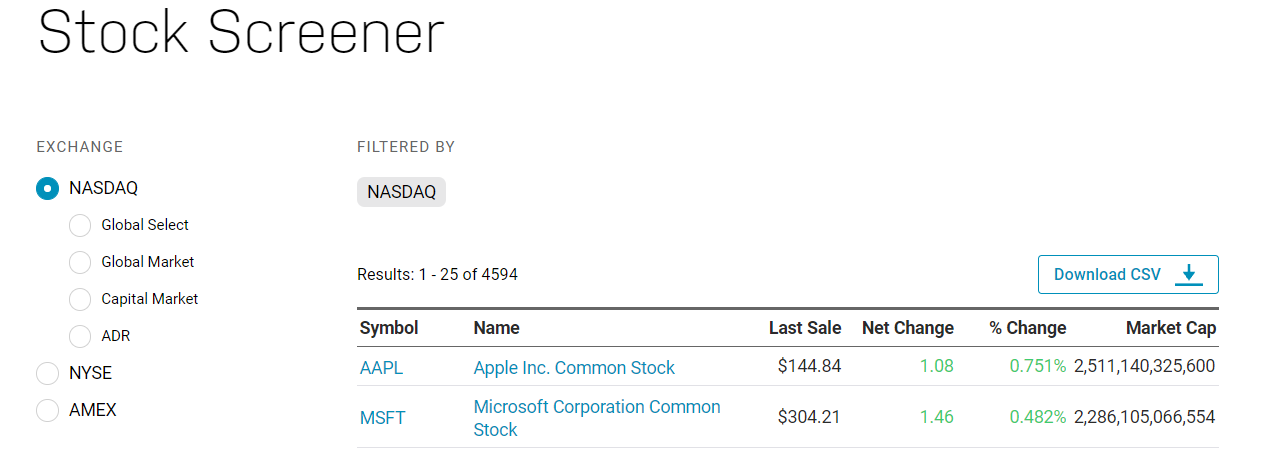

Откроем csv-файл через встроенный в pandas reader:

In [21]:
nasdaq = pd.read_csv('nasdaq_screener.csv')
print(len(nasdaq))
nasdaq.head()

4626


,Symbol,Name,Last Sale,Net Change,% Change,Market Cap,Country,IPO Year,Volume,Sector,Industry
0,AACG,ATA Creativity Global American Depositary Shares,$1.54,0.00,0.00%,4.866183e+07,China,2008.0,4299,Consumer Discretionary,Service to the Health Industry
1,AACI,Armada Acquisition Corp. I Common Stock,$9.91,0.02,0.202%,2.052311e+08,United States,2021.0,3090,Industrials,Consumer Electronics/Appliances
2,AACIW,Armada Acquisition Corp. I Warrant,$0.15,-0.02,-11.765%,0.000000e+00,United States,2021.0,7860,Industrials,Consumer Electronics/Appliances
3,AADI,Aadi Bioscience Inc. Common Stock,$12.82,-0.03,-0.233%,2.684761e+08,United States,NaN,96802,Health Care,Biotechnology: Pharmaceutical Preparations
4,AAL,American Airlines Group Inc. Common Stock,$13.43,-0.32,-2.327%,8.727431e+09,United States,NaN,23978120,Consumer Discretionary,Air Freight/Delivery Services


Биржевые коды для запроса в Yahoo находятся в столбце 'Symbol'. Сохраним значения столбца в отдельном списке и сделаем уже знакомый запрос (который займет намного больше времени):

In [22]:
nasdaq_tickets = nasdaq['Symbol'].tolist()
nasdaq_stocks = yf.download(tickers = nasdaq_tickets[:100], period = '3y', interval = '1d', group_by = 'ticker')

[*********************100%***********************]  100 of 100 completed

4 Failed downloads:
- ACKIU: No data found, symbol may be delisted
- ACKIT: No data found, symbol may be delisted
- ADGI: No data found, symbol may be delisted
- ABTX: No data found, symbol may be delisted


Спустя 5 минут получаем таблицу с дневными ценами закрытия всех акций NASDAQ:

In [23]:
nasdaq_stocks

ADAL                                        ADNWW                 \
            Open   High   Low Close Adj Close    Volume  Open High Low Close   
Date                                                                           
2021-12-29  9.73   9.73  9.73  9.73      9.73     200.0   NaN  NaN NaN   NaN   
2021-12-30  9.78   9.78  9.78  9.78      9.78     100.0   NaN  NaN NaN   NaN   
2021-12-31  6.97  10.00  6.97  9.85      9.85  357800.0   NaN  NaN NaN   NaN   
2022-01-03  9.85   9.86  9.85  9.86      9.86     700.0   NaN  NaN NaN   NaN   
2022-01-04  9.93   9.93  9.87  9.87      9.87     400.0   NaN  NaN NaN   NaN   
...          ...    ...   ...   ...       ...       ...   ...  ...  ..   ...   
2020-12-03   NaN    NaN   NaN   NaN       NaN       NaN   NaN  NaN NaN   NaN   
2020-12-04   NaN    NaN   NaN   NaN       NaN       NaN   NaN  NaN NaN   NaN   
2020-12-07   NaN    NaN   NaN   NaN       NaN       NaN   NaN  NaN NaN   NaN   
2020-12-08   NaN    NaN   NaN   NaN       NaN       NaN   NaN  NaN NaN   NaN   
2020-12-09   NaN    NaN   NaN   NaN       NaN       NaN   NaN  NaN NaN   NaN   

            ...  ACEV                                   ADBE              \
            ...   Low  Close Adj Close    Volume        Open        High   
Date        ...                                                            
2021-12-29  ...  9.96   9.96      9.96  792506.0  573.330017  576.960022   
2021-12-30  ...  9.96   9.97      9.97   85292.0  570.570007  578.989990   
2021-12-31  ...  9.96   9.96      9.96  243947.0  570.000000  570.169983   
2022-01-03  ...  9.96   9.98      9.98   71107.0  566.650024  575.000000   
2022-01-04  ...  9.97   9.97      9.97  102670.0  563.900024  564.299988   
...         ...   ...    ...       ...       ...         ...         ...   
2020-12-03  ...  9.81   9.81      9.81    3705.0  482.209991  492.809998   
2020-12-04  ...  9.81  10.02     10.02  119092.0  485.670013  491.390015   
2020-12-07  ...  9.85   9.96      9.96   44895.0  487.000000  499.290009   
2020-12-08  ...  9.80   9.95      9.95  131514.0  492.290009  496.040009   
2020-12-09  ...  9.82  10.18     10.18  238632.0  496.029999  497.000000   

                                                         
                   Low       Close   Adj Close   Volume  
Date                                                     
2021-12-29  562.780029  569.289978  569.289978  2484200  
2021-12-30  566.039978  570.530029  570.530029  1564600  
2021-12-31  565.070007  567.059998  567.059998  1581400  
2022-01-03  553.270020  564.369995  564.369995  2862700  
2022-01-04  541.309998  554.000000  554.000000  4344800  
...                ...         ...         ...      ...  
2020-12-03  481.500000  484.279999  484.279999  3062700  
2020-12-04  484.359985  486.000000  486.000000  2749800  
2020-12-07  487.000000  492.250000  492.250000  3441700  
2020-12-08  486.200012  495.279999  495.279999  2175700  
2020-12-09  479.260010  483.739990  483.739990  3449100  

[757 rows x 600 columns]

# 2 - Quandl для массовой выгрузки бесплатных и платных данных

**Категория:** Есть платные и бесплатные дата-сеты

**Применение:** Quandl - база данных с различными котировками, индексами и макроэкономическими данными.

**Недостатки:** Некоторые виды данных доступны только после покупки ежемесячной подписки. Подписка осуществляется на каждый датасет в отдельности. С одной стороны - это удобно, если Вам требуются данные по 1-2 биржам и фундаментальные данные. Например, цены по всем китайским акциям с 1997г + обновления будут стоить 50$. С другой стороны, если требуется множество рынков, имеет смысл рассмотреть подписку на терминал Eikon или Bloomberg.

Для выгрузки котировок требуется регистрация на quandle.com и создание api-key. После регистрации api-key можно будет скопировать из личного кабинета по ссылке: https://data.nasdaq.com/account/profile

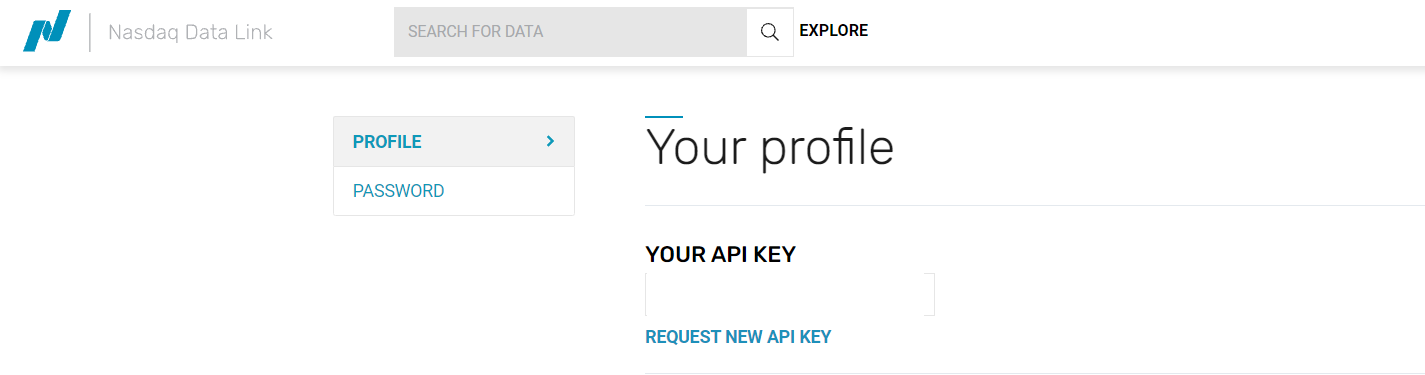

In [15]:
quandl.ApiConfig.api_key = "x4sWJzendrYYa8s3tu5y"

Очередной одиночный запрос для знакомства с построением запросов в новой библиотеки. Рассмотрим дневные цены на нефть на графике:

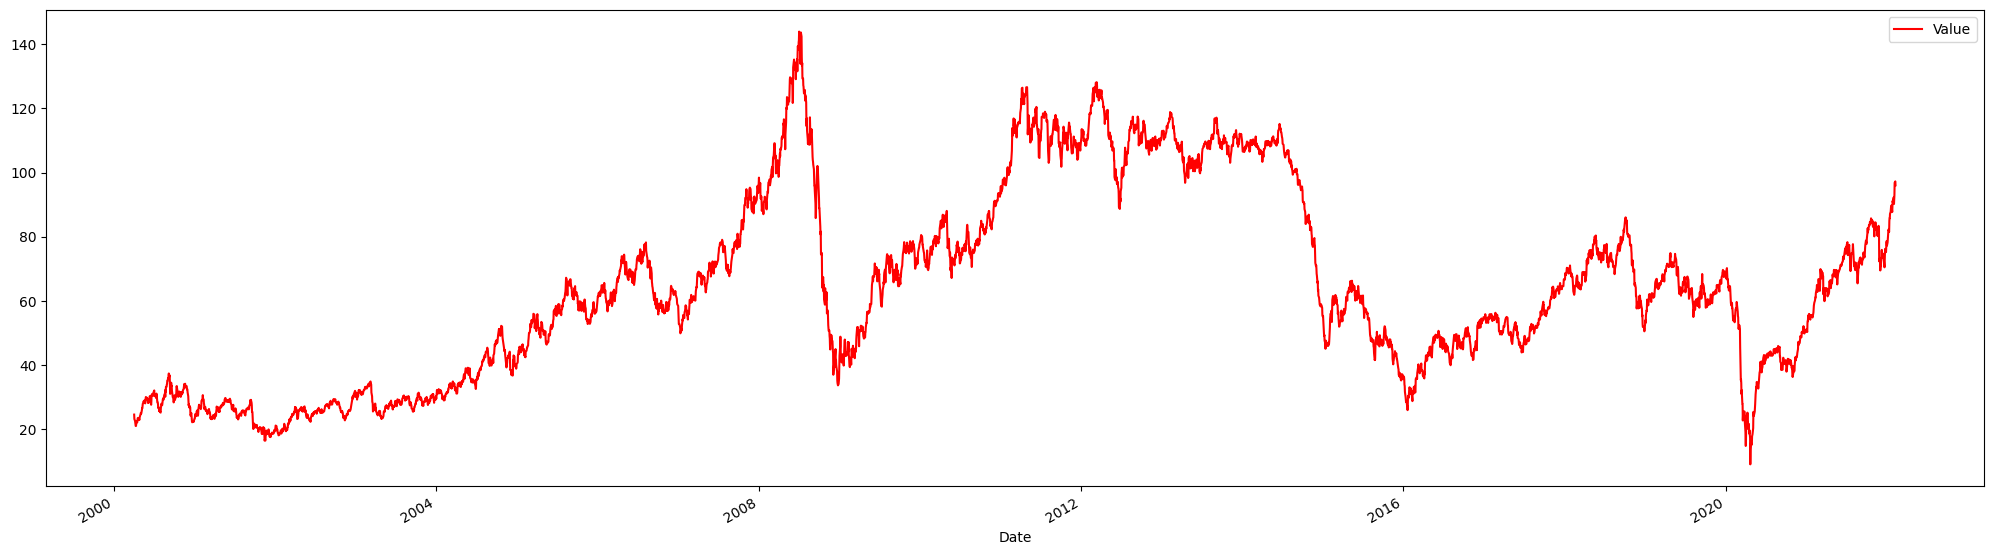

In [24]:
oil = quandl.get(dataset="EIA/PET_RBRTE_D", start_date="2000-04-03", end_date="2023-01-20", collapse="daily")

oil.plot(figsize=(25,7), color='r')
plt.show()

Среди бесплатных полных выборок нам предлагаются акции с Гонконгской и Бомбейской биржи. В примере мы рассмотрим Гонконг, но все команды для Бомбея будут отличаться лишь заменой биржевых кодов.

Скачаем схожий с NASDAQ csv-файл с доступными инструментами: https://data.nasdaq.com/data/HKEX-hong-kong-exchange/usage/export

Откроем его и посмотрим содержимое:

In [25]:
hkex = pd.read_csv('HKEX_metadata.csv')
hkex

,code,name,description,refreshed_at,from_date,to_date
0,00000,119 Poly Property (00000),Stock Prices for 119 Poly Property from the Ho...,2021-10-12 14:00:25,2017-11-03,2021-10-12
1,00001,Ckh Holdings (00001),Stock Prices for Ckh Holdings from the Hong Ko...,2021-10-12 14:00:25,2014-02-21,2021-10-12
2,00002,Clp Holdings (00002),Stock Prices for Clp Holdings from the Hong Ko...,2021-10-12 14:00:25,2014-02-21,2021-10-12
3,00003,Hk China Gas (00003),Stock Prices for Hk China Gas from the Hong Ko...,2021-10-12 14:00:25,2014-02-21,2021-10-12
4,00004,Wharf Holdings (00004),Stock Prices for Wharf Holdings from the Hong ...,2021-10-12 14:00:25,2014-02-21,2021-10-12
...,...,...,...,...,...,...
45152,VHSZ2017,"HSI Volatility Index Futures, December 2017 (V...",Historical Hong Kong Futures Prices: HSI Volat...,2017-12-29 15:01:22,2017-10-03,2017-12-29
45153,VHSZ2018,"HSI Volatility Index Futures, December 2018 (V...",Historical Hong Kong Futures Prices: HSI Volat...,2018-12-31 15:01:29,2018-10-02,2018-12-31
45154,VHSZ2019,"HSI Volatility Index Futures, December 2019 (V...",Historical Hong Kong Futures Prices: HSI Volat...,2019-12-31 15:01:37,2019-10-02,2019-12-31
45155,VHSZ2020,"HSI Volatility Index Futures, December 2020 (V...",Historical Hong Kong Futures Prices: HSI Volat...,2020-12-29 15:11:42,2020-09-30,2020-12-29


Сделаем одиночный тестовый запрос по компании 119 Poly Property с биржевым кодом 00000. На азиатских рынках биржевые коды зачастую представлены в численной комбинации.

Для запроса в dataset мы всегда подставляем биржевой код (HKEX) и через слэш код инструмента:

In [26]:
hkex_poly_property = quandl.get(dataset="HKEX/00000")
hkex_poly_property

,Nominal Price,Net Change,Change (%),Bid,Ask,P/E(x),High,Low,Previous Close,Share Volume (000),Turnover (000),Lot Size
Date,,,,,,,,,,,,
2017-11-03,0.54,None,None,0.53,0.54,None,0.55,0.52,0.54,32850.0,17578.0,None
2017-11-06,0.93,None,None,0.93,0.94,None,0.93,0.93,0.94,144.0,135.0,None
2017-11-07,1.98,None,None,1.97,1.98,None,1.99,1.96,1.98,6121.0,12064.0,None
2017-11-08,1.97,None,None,1.96,1.97,None,1.99,1.95,1.98,6535.0,12851.0,None
2017-11-09,1.86,None,None,1.86,1.87,None,1.87,1.85,1.86,2611.0,4857.0,None
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-16,11.08,None,None,11.06,11.08,None,11.16,10.76,10.98,8018.0,88662.0,None
2023-01-17,11.08,None,None,11.04,11.08,None,11.16,10.70,11.08,9449.0,104163.0,None
2023-01-18,11.04,None,None,11.02,11.04,None,11.40,10.92,11.08,6500.0,72138.0,None


Составим список из всех биржевых кодов на HKEX для выгрузки одним запросом. Обратите внимание, что в выборке содержатся не только акции, а фьючерсы и индексы. Сейчас они нам не нужны, потом обрежем все, что отличается от 5-значного формата акций в столбце 'code':

In [27]:
hkex = hkex[hkex['code'].str.len() == 5]
hkex_tickets = list(hkex['code'])
hkex

,code,name,description,refreshed_at,from_date,to_date
0,00000,119 Poly Property (00000),Stock Prices for 119 Poly Property from the Ho...,2021-10-12 14:00:25,2017-11-03,2021-10-12
1,00001,Ckh Holdings (00001),Stock Prices for Ckh Holdings from the Hong Ko...,2021-10-12 14:00:25,2014-02-21,2021-10-12
2,00002,Clp Holdings (00002),Stock Prices for Clp Holdings from the Hong Ko...,2021-10-12 14:00:25,2014-02-21,2021-10-12
3,00003,Hk China Gas (00003),Stock Prices for Hk China Gas from the Hong Ko...,2021-10-12 14:00:25,2014-02-21,2021-10-12
4,00004,Wharf Holdings (00004),Stock Prices for Wharf Holdings from the Hong ...,2021-10-12 14:00:25,2014-02-21,2021-10-12
...,...,...,...,...,...,...
44334,86657,Prc B2207-r (86657),Stock Prices for Prc B2207-r from the Hong Kon...,2021-10-12 14:01:15,2020-07-28,2021-10-12
44335,86658,Prc B2507-r (86658),Stock Prices for Prc B2507-r from the Hong Kon...,2021-10-12 14:01:15,2020-07-28,2021-10-12
44336,86659,Prc B2309-r (86659),Stock Prices for Prc B2309-r from the Hong Kon...,2021-10-12 14:01:15,2021-09-28,2021-10-12
44337,86660,Prc B2609-r (86660),Stock Prices for Prc B2609-r from the Hong Kon...,2021-10-12 14:01:15,2021-09-28,2021-10-12


Теперь перейдем к главному - составлению запроса на выгрузку всех цен одним запросом. Процедуру можно разделить на 3 этапа:

1) Создание пустой таблицы через pandas.DataFrame(). В нее мы будем последовательно сохранять данные по каждой акции;

2) Запуск цикла по каждой акции из списка. Для этого мы создаем переменную request, которая всегда состоит из кода Гонконгской биржи и тикера инструмента, по которому совершается запрос. Также нас интересует только столбец с ценой закрытия (Nominal Price), поэтому отрезаем все остальные показатели;

3) Сохраняем данные в исходную пустую таблицу через pd.concat. Это команда используется для сшивания таблиц.

In [28]:
hkex_close_price = pd.DataFrame()

for i in tqdm(range(len(hkex_tickets[:10]))):
    
    request = 'HKEX/' + hkex_tickets[i]
    close_price = quandl.get(dataset=request)
    close_price = close_price['Nominal Price']
    hkex_close_price = pd.concat([hkex_close_price, close_price], axis=1)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:21<00:00,  2.16s/it]


Переименуем столбцы согласно списку кодов и посмотрим, что получилось:

In [29]:
hkex_close_price.columns = hkex_tickets[:10]
hkex_close_price

,00000,00001,00002,00003,00004,00005,00006,00007,00008,00009
2017-11-03,0.54,99.15,79.30,14.80,74.75,75.60,67.50,0.89,4.30,0.280
2017-11-06,0.93,98.20,78.85,14.70,74.00,75.30,67.25,0.90,4.29,0.275
2017-11-07,1.98,99.00,78.95,14.72,75.45,75.80,67.45,0.90,4.28,0.275
2017-11-08,1.97,98.70,79.45,14.86,74.30,75.35,67.60,0.89,4.29,0.275
2017-11-09,1.86,98.70,79.65,14.82,75.10,75.85,67.40,0.88,4.27,0.275
...,...,...,...,...,...,...,...,...,...,...
2017-11-02,NaN,99.20,78.85,14.78,71.85,75.85,67.15,0.89,4.28,0.275
2014-02-26,NaN,NaN,60.05,16.54,52.75,81.15,64.55,2.04,3.51,0.700
2014-04-29,NaN,NaN,62.25,NaN,54.55,79.60,NaN,1.61,NaN,0.640
2014-05-14,NaN,NaN,62.65,18.02,54.25,NaN,NaN,1.40,4.17,0.640


# https://data.nasdaq.com/data/BSE-bombay-stock-exchange

# SimFin

**Категория**: Есть ограниченный доступ по бесплатной подписке

**Применение**: Подходит для выгрузки ценовых и финансовых данных по акциям США, Германии, Канады и Китая. В библиотеке есть встроенные функции для расчета финансовых мультипликаторов на основе отчетности.

**Недостатки**: Сравнительно небольшой список инструментов, ограниченный функционал и количество запросов в бесплатной версии.

SimFin - сравнительно новый сервис с упором на фундаментальные данные. Его сложно назвать альтернативой терминалу Eikon по наполнению и функционалу, но и месячная стоимость его примерно в 100 раз дешевле.

api-key можно получить на сайте. Также там есть веб-версия библиотеки: https://simfin.com/

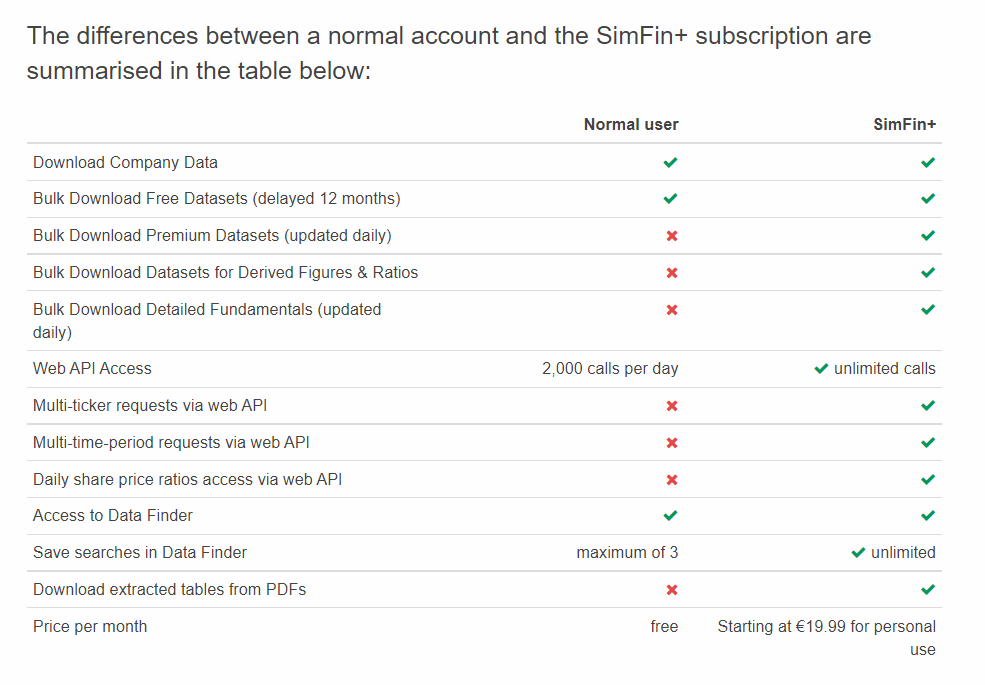

Воспользуемся тестовым ключом и выберем директорию, куда будут сохраняться данные со всех запросов:

In [30]:
sf.set_api_key(api_key='NcsdUsdeEeENElwX6IZ0QBeePXjP4QX6')
sf.set_data_dir('/content/sample_data')

Одиночный запрос по акция Apple. Хотим получить ряды по выручке и чистой прибыли:

In [31]:
df = sf.load_income(variant='annual', market='us')
df
#

Dataset "us-income-annual" on disk (247 days old).
- Downloading ... 100.0%
- Extracting zip-file ... Done!
- Loading from disk ... Done!


SimFinId Currency  Fiscal Year Fiscal Period Publish Date  \
Ticker Report Date                                                              
A      2017-10-31      45846      USD         2017            FY   2017-12-21   
       2018-10-31      45846      USD         2018            FY   2018-12-20   
       2019-10-31      45846      USD         2019            FY   2019-12-19   
       2020-10-31      45846      USD         2020            FY   2020-12-18   
       2021-10-31      45846      USD         2021            FY   2021-12-17   
...                      ...      ...          ...           ...          ...   
ZYXI   2017-12-31     171401      USD         2017            FY   2018-02-28   
       2018-12-31     171401      USD         2018            FY   2019-02-26   
       2019-12-31     171401      USD         2019            FY   2020-02-27   
       2020-12-31     171401      USD         2020            FY   2021-02-25   
       2021-12-31     171401      USD         2021            FY   2022-03-22   

                   Restated Date  Shares (Basic)  Shares (Diluted)  \
Ticker Report Date                                                   
A      2017-10-31     2018-12-20     322000000.0       326000000.0   
       2018-10-31     2020-12-18     321000000.0       325000000.0   
       2019-10-31     2021-12-17     314000000.0       318000000.0   
       2020-10-31     2022-12-21     309000000.0       312000000.0   
       2021-10-31     2022-12-21     305000000.0       307000000.0   
...                          ...             ...               ...   
ZYXI   2017-12-31     2019-02-26      35371600.0        36515600.0   
       2018-12-31     2019-02-26      35753300.0        37447300.0   
       2019-12-31     2021-02-25      35682900.0        37359300.0   
       2020-12-31     2022-03-22      37255900.0        38437300.0   
       2021-12-31     2022-03-22      37255900.0        38437300.0   

                         Revenue  Cost of Revenue  ...  \
Ticker Report Date                                 ...   
A      2017-10-31   4.472000e+09    -2.063000e+09  ...   
       2018-10-31   4.914000e+09    -2.234000e+09  ...   
       2019-10-31   5.163000e+09    -2.358000e+09  ...   
       2020-10-31   5.339000e+09    -2.502000e+09  ...   
       2021-10-31   6.319000e+09    -2.912000e+09  ...   
...                          ...              ...  ...   
ZYXI   2017-12-31   2.343200e+07    -4.819000e+06  ...   
       2018-12-31   3.191700e+07    -6.038000e+06  ...   
       2019-12-31   4.547200e+07    -8.814000e+06  ...   
       2020-12-31   8.012200e+07    -1.741700e+07  ...   
       2021-12-31   1.303010e+08    -2.732100e+07  ...   

                    Non-Operating Income (Loss)  Interest Expense, Net  \
Ticker Report Date                                                       
A      2017-10-31                   -38000000.0            -57000000.0   
       2018-10-31                    42000000.0            -37000000.0   
       2019-10-31                   -22000000.0            -38000000.0   
       2020-10-31                    -4000000.0            -70000000.0   
       2021-10-31                    13000000.0            -79000000.0   
...                                         ...                    ...   
ZYXI   2017-12-31                    -1450000.0             -1450000.0   
       2018-12-31                     -154000.0              -154000.0   
       2019-12-31                       -5000.0                -5000.0   
       2020-12-31                      -19000.0               -19000.0   
       2021-12-31                      -95000.0               -95000.0   

                    Pretax Income (Loss), Adj.  Abnormal Gains (Losses)  \
Ticker Report Date                                                        
A      2017-10-31                    803000000                      NaN   
       2018-10-31                    946000000                      NaN   
       2019-10-31                    

In [48]:
print(df.loc['AAPL', [REVENUE, NET_INCOME]])

                  Revenue   Net Income
Report Date                           
2016-09-30   2.156390e+11  45687000000
2017-09-30   2.292340e+11  48351000000
2018-09-30   2.655950e+11  59531000000
2019-09-30   2.601740e+11  55256000000
2020-09-30   2.745150e+11  57411000000


Массированный запрос по показателям из отчета о прибылях и убытках (dataset='income') американских компаний (market='us'):

In [26]:
us_fy = sf.load(dataset='income', variant='annual', market='us',
              index=[TICKER, REPORT_DATE])

Dataset "us-income-annual" on disk (0 days old).
- Loading from disk ... Done!


In [27]:
us_fy

SimFinId Currency  Fiscal Year Fiscal Period Publish Date  \
Ticker Report Date                                                              
A      2016-10-31      45846      USD         2016            FY   2016-12-20   
       2017-10-31      45846      USD         2017            FY   2017-12-21   
       2018-10-31      45846      USD         2018            FY   2018-12-20   
       2019-10-31      45846      USD         2019            FY   2019-12-19   
       2020-10-31      45846      USD         2020            FY   2020-12-18   
...                      ...      ...          ...           ...          ...   
ZYXI   2016-12-31     171401      USD         2016            FY   2017-04-18   
       2017-12-31     171401      USD         2017            FY   2018-02-28   
       2018-12-31     171401      USD         2018            FY   2019-02-26   
       2019-12-31     171401      USD         2019            FY   2020-02-27   
       2020-12-31     171401      USD         2020            FY   2021-02-25   

                   Restated Date  Shares (Basic)  Shares (Diluted)  \
Ticker Report Date                                                   
A      2016-10-31     2018-12-20     326000000.0       329000000.0   
       2017-10-31     2018-12-20     322000000.0       326000000.0   
       2018-10-31     2020-12-18     321000000.0       325000000.0   
       2019-10-31     2021-12-17     314000000.0       318000000.0   
       2020-10-31     2021-12-17     309000000.0       312000000.0   
...                          ...             ...               ...   
ZYXI   2016-12-31     2018-02-28      34398357.0        34398357.0   
       2017-12-31     2019-02-26      35371600.0        36515600.0   
       2018-12-31     2019-02-26      35753300.0        37447300.0   
       2019-12-31     2021-02-25      35682900.0        37359300.0   
       2020-12-31     2022-03-22      37255900.0        38437300.0   

                         Revenue  Cost of Revenue  ...  \
Ticker Report Date                                 ...   
A      2016-10-31   4.202000e+09    -2.005000e+09  ...   
       2017-10-31   4.472000e+09    -2.063000e+09  ...   
       2018-10-31   4.914000e+09    -2.234000e+09  ...   
       2019-10-31   5.163000e+09    -2.358000e+09  ...   
       2020-10-31   5.339000e+09    -2.502000e+09  ...   
...                          ...              ...  ...   
ZYXI   2016-12-31   1.331300e+07    -3.517000e+06  ...   
       2017-12-31   2.343200e+07    -4.819000e+06  ...   
       2018-12-31   3.191700e+07    -6.038000e+06  ...   
       2019-12-31   4.547200e+07    -8.814000e+06  ...   
       2020-12-31   8.012200e+07    -1.741700e+07  ...   

                    Non-Operating Income (Loss)  Interest Expense, Net  \
Ticker Report Date                                                       
A      2016-10-31                   -71000000.0            -61000000.0   
       2017-10-31                   -38000000.0            -57000000.0   
       2018-10-31                    42000000.0            -37000000.0   
       2019-10-31                   -22000000.0            -38000000.0   
       2020-10-31                    -4000000.0            -70000000.0   
...                                         ...                    ...   
ZYXI   2016-12-31                     -556000.0              -352000.0   
       2017-12-31                    -1450000.0             -1450000.0   
       2018-12-31                     -154000.0              -154000.0   
       2019-12-31                       -5000.0                -5000.0   
       2020-12-31                      -19000.0               -19000.0   

                    Pretax Income (Loss), Adj.  Abnormal Gains (Losses)  \
Ticker Report Date                                                        
A      2016-10-31                    544000000                      NaN   
       2017-10-31                    803000000                      NaN   
       2018-10-31                    

В библиотеке есть встроенные функции расчета мультипликаторов на основе отчетности. Для этого создадим hub с основными параметрами и применим функцию val_signals:

In [49]:
hub = sf.StockHub(market='us',
                  refresh_days=30,
                  refresh_days_shareprices=1)

In [50]:
df_val_signals = hub.val_signals(variant='latest')
df_val_signals

Dataset "us-shareprices-latest" on disk (0 days old).
- Loading from disk ... Done!
Dataset "us-income-ttm" on disk (0 days old).
- Loading from disk ... Done!
Dataset "us-balance-ttm" on disk (0 days old).
- Loading from disk ... Done!
Dataset "us-cashflow-ttm" on disk (0 days old).
- Loading from disk ... Done!
Cache-file 'val_signals-9541e2e6.pickle' on disk (0 days old).
- Loading from disk ... Done!


,,Dividend Yield,Earnings Yield,FCF Yield,Market-Cap,P/Cash,P/E,P/FCF,P/NCAV,P/NetNet,P/Sales,Price to Book Value
Ticker,Date,,,,,,,,,,,
A,2022-05-17,0.006002,0.024243,0.032866,3.815480e+10,27.648406,41.248432,30.426475,-18.396721,-12.691825,6.559189,7.932391
AA,2022-05-17,NaN,-0.006343,0.046092,1.182410e+10,4.647838,-157.654667,21.695596,-2.288388,-1.857602,1.209627,2.426452
AAL,2022-05-17,-0.000000,-0.826293,-0.727900,9.553516e+09,0.680498,-1.210225,-1.373816,-0.163294,-0.156621,0.744623,-1.202456
AAMC,2022-05-17,NaN,-0.164625,-0.403357,1.712378e+07,0.439612,-6.074418,-2.479193,0.490316,0.617429,1.177180,0.407418
AAME,2022-05-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
ZUO,2022-05-17,NaN,-0.059076,0.006924,1.241561e+09,6.289634,-16.927226,144.417964,28.209607,-2038.688399,3.981264,7.239129
ZVO,2022-05-17,NaN,-2.687802,1.341745,2.249608e+07,0.617719,-0.372051,0.745298,-0.738424,-0.332788,0.059813,0.441914
ZY,2022-05-17,NaN,-15.613703,-14.586471,1.802513e+07,0.148925,-0.064046,-0.068557,-2.360237,-0.831647,1.281559,0.225695


# 3 - Refinitiv Eikon

**Категория**: Платный и дорогой

**Применение**: Подходит для выгрузки всех биржевых, финансовых и некоторых альтернативных данных по всем странам, где присутствует биржевая торговля + индексы, облигации и другие инструменты. В отличие от предыдущих платформ, хранит историю по США/Великобритании/Канаде с 1970-х годов.

**Недостатки**: Стоимость. Годовая подписка на терминал стоит 22.000$*. 

*Источник: https://www.wallstreetprep.com/knowledge/bloomberg-vs-capital-iq-vs-factset-vs-thomson-reuters-eikon/

В Eikon потребуется регистрация API-ключа. Также можно работать через встроенную среду разработки. В нее можно попасть набрав CodeBook в поиске:

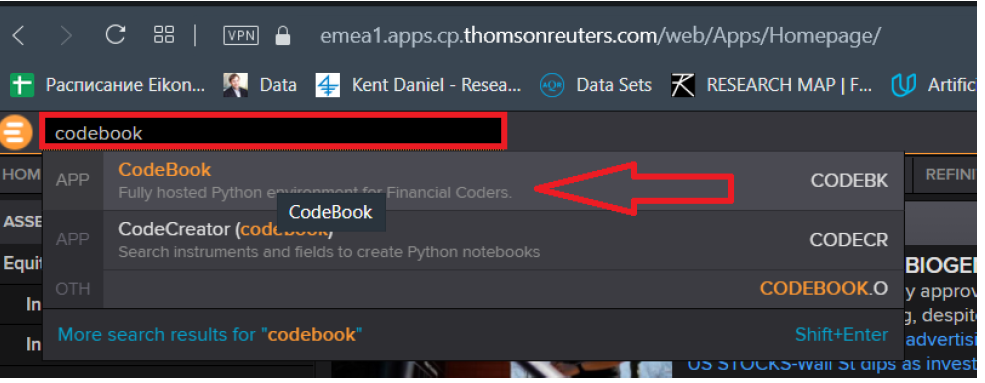

Вводим API-ключ:

In [ ]:
import eikon as ek

In [2]:
from importlib.metadata import version
version('eikon')

'1.1.12'

In [3]:
ek.set_app_key("enter yout API-key here")

Устанавливаем параметры для всех последующих запросов:

In [4]:
start = datetime.datetime(2019,1,1) #год - месяц - день
end = datetime.datetime(2021,5,15)

Структура запроса не сильно отличается от предыдущих вариантов и интуитивно понятна: список с кодами акций, целевой показатель, дата начала и конца + интервал).

Важным отличием является использование собственных RIC-кодов, которые отличаются от биржевых кодов:

In [6]:
us_stocks = ['TSLA.O', 'AAPL.O', 'INTC.O', 'FB.O']

multiple_stocks = ek.get_timeseries(us_stocks, 
                         fields='CLOSE',  
                         start_date=start, 
                         end_date=end,
                         interval='daily') 

multiple_stocks.head()

CLOSE,TSLA.O,AAPL.O,INTC.O,FB.O
Date,,,,
2019-01-02,62.024,39.48,47.08,135.68
2019-01-03,60.072,35.5475,44.49,131.74
2019-01-04,63.538,37.065,47.22,137.95
2019-01-07,66.992,36.9825,47.44,138.05
2019-01-08,67.07,37.6875,47.74,142.53


**Конечно, так использовать Eikon неэффективно**

Поэтому перейдем к делу: выгрузим цены и фундаментальные показатели для всех инструментов с одной из бирж. Например, для Аргентинской биржи MIC код будет XBUE.

Замените 'XBUE' в первой строке на код нужной биржи при необходимости.

Полный список страновых кодов можно посмотреть здесь https://support.microsoft.com/ru-ru/office/сведения-о-финансовых-источниках-данных-акций-98a03e23-37f6-4776-beea-c5a6c8e787e6

In [ ]:
screener_exp ='SCREEN(U(IN(Equity(public))), IN(TR.ExchangeMarketIdCode, XBUE))'# Вместо XBUE поставьте MIC-код
xbue, e = ek.get_data(screener_exp, 'TR.CompanyName')
xbue

Количество инструментов:

In [ ]:
xbue_rics = list(set(xbue['Instrument']))
len(xbue_rics)

375

Установим параметры, которые будем использовать для каждого запроса. Это стартовая дата, конечная дата и временной шаг.

In [ ]:
params = {'Frq': 'M', 'sDate': '2016-01-01','eDate': '2021-05-31'}

Следующий блок выполняет запрос данных по выбранному показателю. Сейчас мы выбрали цену.

Для больших площадок вроде NYSE или TSE имеет смысл устанавливать короткие интервалы, т.к. есть ограничения на количество запросов в одной команде.

In [ ]:
price = ['TR.PriceClose.date', 'TR.PriceClose']
xbue_price = ek.get_data(xbue_rics, price, params, field_name=True)[0]
xbue_price

,Instrument,TR.PRICECLOSE.DATE,TR.PRICECLOSE
0,FERR5.BA,2009-05-28T00:00:00Z,<NA>
1,FERR5.BA,2009-05-28T00:00:00Z,<NA>
2,FERR5.BA,2009-05-28T00:00:00Z,<NA>
3,FERR5.BA,2009-05-28T00:00:00Z,<NA>
4,FERR5.BA,2009-05-28T00:00:00Z,<NA>
...,...,...,...
22066,MDT.BA,2021-01-25T00:00:00Z,4479.064325
22067,MDT.BA,2021-02-25T00:00:00Z,4315.945866
22068,MDT.BA,2021-03-22T00:00:00Z,4384.862176
22069,MDT.BA,2021-04-28T00:00:00Z,5098.782625


Теперь скачаем данные по мультипликатору P/BV для тех же компаний:

In [ ]:
pbv = ['TR.PriceToBVPerShare.date','TR.PriceToBVPerShare']
xbue_pbv = ek.get_data(xbue_rics, pbv, params, field_name=True)[0]
xbue_pbv

2021-10-15 22:20:13,117 P[2012] [MainThread 2660] An open stream object is being garbage collected; call "stream.close()" explicitly.


,Instrument,TR.PRICETOBVPERSHARE.DATE,TR.PRICETOBVPERSHARE
0,FERR5.BA,2016-01-29T00:00:00Z,22.65626
1,FERR5.BA,2016-02-29T00:00:00Z,23.944055
2,FERR5.BA,2016-03-31T00:00:00Z,26.179242
3,FERR5.BA,2016-04-29T00:00:00Z,25.719957
4,FERR5.BA,2016-05-31T00:00:00Z,21.434894
...,...,...,...
22962,MDT.BA,2021-01-29T00:00:00Z,2.986202
22963,MDT.BA,2021-02-26T00:00:00Z,3.137484
22964,MDT.BA,2021-03-31T00:00:00Z,3.135993
22965,MDT.BA,2021-04-30T00:00:00Z,3.475529


На самом деле, список инструментов включает в себя только торгуемые на данный момент. Но Eikon хранит данные по делистингованным компаниям. Для их получения нужно отразить в списке кодов такие компании + специальный синтаксис. 

In [ ]:
rus_rics = pd.read_csv('rus_rics.txt', sep='\t', header=None)
rus_rics = list(rus_rics[0])

In [ ]:
rus_price = ek.get_data(rus_rics, price, params, field_name=True)[0]
rus_price

2021-10-15 22:27:49,898 P[2012] [MainThread 2660] An open stream object is being garbage collected; call "stream.close()" explicitly.


,Instrument,TR.PRICECLOSE.DATE,TR.PRICECLOSE
0,ABRD.MM,2016-01-29T00:00:00Z,112.5
1,ABRD.MM,2016-02-29T00:00:00Z,102.0
2,ABRD.MM,2016-03-31T00:00:00Z,83.5
3,ABRD.MM,2016-04-29T00:00:00Z,81.0
4,ABRD.MM,2016-05-31T00:00:00Z,82.5
...,...,...,...
25202,ZVEZ.MM,2021-01-29T00:00:00Z,4.195
25203,ZVEZ.MM,2021-02-26T00:00:00Z,4.405
25204,ZVEZ.MM,2021-03-31T00:00:00Z,4.25
25205,ZVEZ.MM,2021-04-30T00:00:00Z,4.19


In [10]:
from tqdm import tqdm

start_date = '2021-02-26'
end_date = '2021-08-31'
timestamp = 'M'

params = {'Frq': timestamp, 'sDate': start_date,'eDate': end_date}

close_price = ['TR.PriceClose.date', 'TR.PriceClose']
pbv = ['TR.PriceToBVPerShare.date','TR.PriceToBVPerShare']
mcap = ['TR.IssueMarketCap.date','TR.IssueMarketCap']


factors = [close_price, pbv, mcap]
factors_names = ['close_price', 'pbv', 'mcap']

In [14]:
%cd C:/Users/tomtosov/Desktop
rus_rics = pd.read_csv('rus_rics.txt', sep='\t', header=None)
rus_rics = list(rus_rics[0])

C:\Users\tomtosov\Desktop


In [15]:
rus_rics

['ABRD.MM',
 'ACKO.MM',
 'AESL.MM^C17',
 'AFKS.MM',
 'AFLT.MM',
 'AGRO.MM',
 'AKHA.MML^C14',
 'AKRN.MM',
 'ALBK.MM',
 'ALNU.MM',
 'ALRS.MM',
 'AMEZ.MM',
 'APDS.MM^H12',
 'APDS_p.MM^H12',
 'APTK.MM',
 'AQUA.MM',
 'ARHE.MM^D08',
 'ARHE_p.MM^D08',
 'ARMD.MM',
 'ARSA.MM',
 'ARSB.MM^H12',
 'ARSB_p.MM^H12',
 'ASRE.MM^D08',
 'ASSB.MM',
 'AVAGI.RTS^C17',
 'AVAN.MM',
 'AVAZI.MM',
 'AVAZI_p.MM',
 'AZKM.RTS^D13',
 'BACT.MM^L12',
 'BANE.MM',
 'BANE_p.MM',
 'BEGY.MM^K12',
 'BEGY_p.MM',
 'BELU.MM',
 'BENRI.MM',
 'BENRI_p.MM',
 'BFMA.MM^L08',
 'BGDE.MM^F17',
 'BISV.MM',
 'BISV_p.MM',
 'BLNG.MM',
 'BLRS.MM^D08',
 'BLRS_p.MM^D08',
 'BLSB.MM^J09',
 'BLSB_p.MM^J09',
 'BNSB.MM^F12',
 'BNSB_p.MM^F12',
 'BREN.MM^D08',
 'BREN_p.MM^D08',
 'BRZL.MM',
 'BSPB.MM',
 'BSPB_p.MM',
 'BUSB.MM^A11',
 'CBOM.MM',
 'CHEP.MM',
 'CHGZ.MM',
 'CHKZ.MM',
 'CHMF.MM',
 'CHMK.MM',
 'CHNG.MM^E08',
 'CHNG_p.MM^E08',
 'CHSB.MM^J10',
 'CHSB_p.MM^J10',
 'CHZNI.MM',
 'CLSB.MM',
 'CLSB_p.MM',
 'CMST.MM^D11',
 'CNTL.MM',
 'CNTL_p.MM',
 

In [11]:
def get_pqr_matrix(eikon_matrix, tickers):

    main_df = pd.DataFrame()

    for i in tqdm(range(len(tickers))):

        single_stock = eikon_matrix[eikon_matrix['Instrument'] == tickers[i]]
        single_stock.columns = ['Instrument', 'Date', tickers[i]]
        single_stock.index = single_stock['Date']
        single_stock.index = single_stock.index.map(lambda x: str(x)[:-13])

        single_stock = single_stock.drop_duplicates(subset='Date', keep="first")
        single_stock.drop(['Instrument', 'Date'], axis = 1, inplace=True)
        
        main_df = main_df.join(single_stock, how='outer')
        
    return main_df

In [12]:
def get_eikon_data(factor, factor_name, params, rics):
    
    print(factor_name)
    
    eikon_df = ek.get_data(rics, factor, params, field_name=True)[0]
    pqr_matrix = get_pqr_matrix(eikon_df, rics)
    pqr_matrix.columns = pqr_matrix.columns.str.split('.').str[0]
    pqr_matrix = pqr_matrix.loc[start_date:]

    today = str(datetime.date.today())   
    csv_name = 'rus_' + factor_name + '_' + today + '.csv'
    print(csv_name)
    pqr_matrix.to_csv(csv_name)
    time.sleep(30)

In [16]:
for i in range(len(factors)):
    
    get_eikon_data(factors[i], factors_names[i], params, rus_rics)

2021-11-16 19:56:04,354 P[24484] [MainThread 24492] An open stream object is being garbage collected; call "stream.close()" explicitly.


close_price


100%|████████████████████████████████████████████████████████████████████████████████| 567/567 [00:21<00:00, 25.84it/s]


rus_close_price_2021-11-16.csv


2021-11-16 19:57:01,700 P[24484] [MainThread 24492] An open stream object is being garbage collected; call "stream.close()" explicitly.


pbv


100%|████████████████████████████████████████████████████████████████████████████████| 567/567 [00:22<00:00, 25.23it/s]


rus_pbv_2021-11-16.csv


2021-11-16 19:57:57,737 P[24484] [MainThread 24492] An open stream object is being garbage collected; call "stream.close()" explicitly.


mcap


100%|████████████████████████████████████████████████████████████████████████████████| 567/567 [00:22<00:00, 25.29it/s]


rus_mcap_2021-11-16.csv


In [18]:
close_price = pd.read_csv('rus_close_price_2021-11-16.csv', index_col=0)
close_price

,ABRD,ACKO,AESL,AFKS,AFLT,AGRO,AKHA,AKRN,ALBK,ALNU,...,YRSB_p,YRSLI,YUKO,ZAGR,ZHIVI,ZILL,ZMZNI,ZMZNI_p,ZOYA,ZVEZ
Date,,,,,,,,,,,,,,,,,,,,,
2021-03,211.5,6.24,NaN,34.260,67.26,NaN,NaN,6206.0,59.5,61800.0,...,92.0,NaN,NaN,NaN,NaN,3230.0,NaN,NaN,NaN,4.250
2021-04,202.0,6.10,NaN,33.870,64.16,NaN,NaN,5982.0,59.5,65800.0,...,91.5,NaN,NaN,NaN,NaN,3730.0,NaN,NaN,NaN,4.190
2021-05,199.5,6.10,NaN,31.625,69.90,NaN,NaN,6050.0,64.5,65400.0,...,92.0,NaN,NaN,NaN,NaN,3655.0,NaN,NaN,NaN,4.160
2021-06,200.0,5.94,NaN,31.700,68.38,NaN,NaN,5932.0,64.0,NaN,...,92.5,NaN,NaN,NaN,NaN,4045.0,NaN,NaN,NaN,4.045
2021-07,195.0,5.70,NaN,29.500,67.48,NaN,NaN,6052.0,64.0,65600.0,...,91.5,NaN,NaN,NaN,NaN,4040.0,NaN,NaN,NaN,4.010
2021-08,195.0,5.72,NaN,30.370,69.28,NaN,NaN,6562.0,151.0,65400.0,...,91.5,NaN,NaN,NaN,NaN,4195.0,NaN,NaN,NaN,4.205
